In [2]:
from geostat import GP, Model, Mesh, NormalizingFeaturizer, Parameters
import geostat.kernel as krn
import matplotlib.pyplot as pp
import numpy as np
from shapely.geometry import Point, Polygon
import shapely.vectorized as shv
import geopandas as gpd
import contextily as ctx

# Overview

In this notebook we will show how `Mesh` is used to make prediction locations. We will:
  * Generate synthetic data on a map of watersheds in Berkeley, California.
  * Fit a Gaussian Process `Model` to the data.
  * Make predictions using `Mesh`.

# Synthesizing data

We will synthesize data at 200 random locations drawn from inside a polygon for Berkeley watersheds.

In [3]:
berkeleydf = gpd.read_file("./berkeley-watershed.zip")
berkeley = berkeleydf['geometry'].iloc[0]

x0, y0, x1, y1 = berkeley.bounds
locs = np.random.uniform(size = [2000, 2]) * [x1-x0, y1-y0] + [x0, y0] # Generate 2000 points.
mask = [berkeley.contains(Point(p)) for p in locs]
locs = locs[mask, :][:200, :] # Filter away points outside of shape and keep just 200.

Declare the terms of the spatial trend:

In [4]:
def trend_terms(x, y): return x, y

Create a featurizer that the Gaussian process class `GP` will use to convert locations into trend features:

In [5]:
featurizer = NormalizingFeaturizer(trend_terms, locs)

Make geostatistical parameters for the `GP`, instiate the `GP`, instantiate a `Model`, and call `generate` to generate synthetic observations.

In [6]:
p = Parameters(alpha=0.25, range=2000, sill=1., nugget=0.25)

gp = GP(0, krn.TrendPrior(featurizer, alpha=p.alpha) + \
           krn.SquaredExponential(range=p.range, sill=p.sill) + \
           krn.Noise(nugget=p.nugget))

model = Model(gp)

obs = model.generate(locs).vals

vmin, vmax = obs.min(), obs.max()

When the data is plotted, you can see an overall trend with some localized variations.

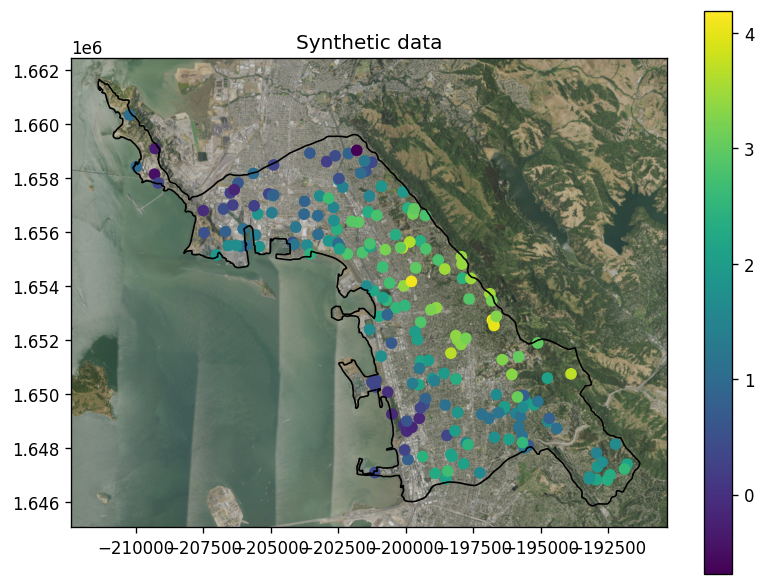

In [7]:
fig, ax = pp.subplots(figsize=(7, 7), dpi=120)

cax = pp.scatter(locs[:, 0], locs[:, 1], c=obs, vmin=vmin, vmax=vmax)

berkeleydf.plot(ax=ax, fc='none', ec='black', lw=1)

pp.colorbar(cax, shrink=0.7)

ctx.add_basemap(ax, attribution=False, crs=berkeleydf.crs.to_string(), 
                source='https://basemap.nationalmap.gov/arcgis/rest/services/'
                       'USGSImageryOnly/MapServer/tile/{z}/{y}/{x}')

pp.title('Synthetic data')

pp.tight_layout()
pp.show()

# Inferring parameters

Now set the parameters to something arbitrary to see if we can successfully infer model parameters. We call `fit` with the data (`locs` and `obs`).

In [8]:
model.set(alpha=1.0, range=1000.0, sill=0.5, nugget=0.5)
model.fit(locs, obs, iters=300)
None

[iter    30 ll -194.17 time  1.49 reg  0.00 alpha  1.24 sill  0.42 range 1336.73 nugget  0.37]
[iter    60 ll -184.73 time  0.36 reg  0.00 alpha  1.12 sill  0.52 range 1687.33 nugget  0.29]
[iter    90 ll -181.58 time  0.35 reg  0.00 alpha  1.01 sill  0.68 range 1964.81 nugget  0.25]
[iter   120 ll -180.89 time  0.34 reg  0.00 alpha  0.96 sill  0.85 range 2135.51 nugget  0.24]
[iter   150 ll -180.72 time  0.35 reg  0.00 alpha  0.93 sill  0.99 range 2234.71 nugget  0.24]
[iter   180 ll -180.67 time  0.35 reg  0.00 alpha  0.92 sill  1.08 range 2291.47 nugget  0.24]
[iter   210 ll -180.66 time  0.35 reg  0.00 alpha  0.91 sill  1.13 range 2321.38 nugget  0.24]
[iter   240 ll -180.66 time  0.35 reg  0.00 alpha  0.91 sill  1.16 range 2336.16 nugget  0.24]
[iter   270 ll -180.65 time  0.34 reg  0.00 alpha  0.90 sill  1.17 range 2342.93 nugget  0.24]
[iter   300 ll -180.65 time  0.34 reg  0.00 alpha  0.90 sill  1.18 range 2345.77 nugget  0.24]


# Generating predictions in convex hull

Create a mesh using a convex hull for making predictions.

In [9]:
mesh = Mesh.from_convex_hull(locs, nx=200)

Call `Model` to get predictions at mesh locations:

In [10]:
mean, var = model.predict(mesh.locations())

Create a slice for prediction mean and plot:

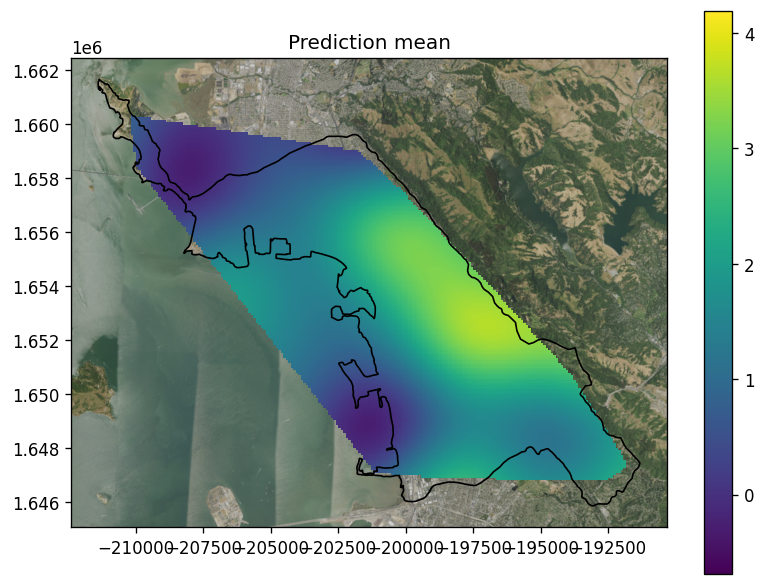

In [11]:
meshx, meshy, value = mesh.slice(mean)

fig, ax = pp.subplots(figsize=(7, 7), dpi=120)

cax = pp.pcolormesh(meshx, meshy, value, vmin=vmin, vmax=vmax)

berkeleydf.plot(ax=ax, fc='none', ec='black', lw=1)

pp.colorbar(cax, shrink=0.7)

ctx.add_basemap(ax, attribution=False, crs=berkeleydf.crs.to_string(), 
                source='https://basemap.nationalmap.gov/arcgis/rest/services/'
                       'USGSImageryOnly/MapServer/tile/{z}/{y}/{x}')

pp.title('Prediction mean')

pp.tight_layout()
pp.show()

Do the same for prediction variance:

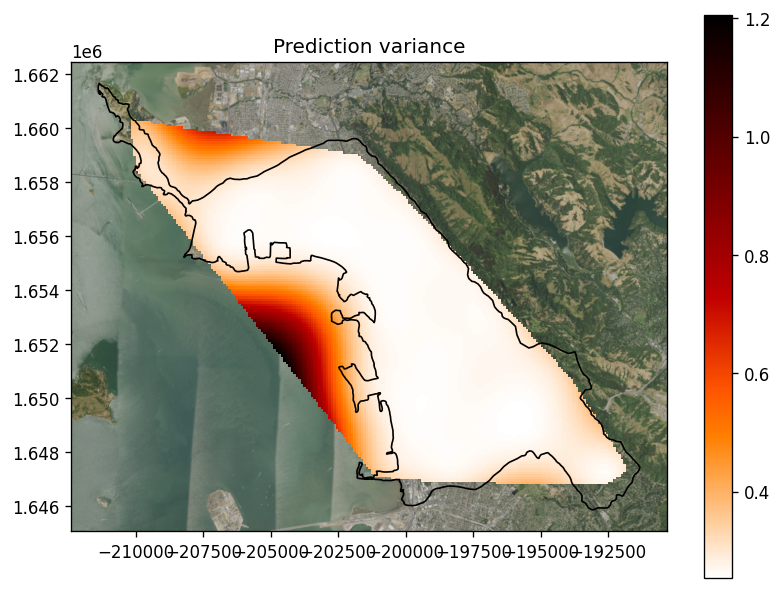

In [12]:
meshx, meshy, value = mesh.slice(var)

fig, ax = pp.subplots(figsize=(7, 7), dpi=120)

cax = pp.pcolormesh(meshx, meshy, value, cmap='gist_heat_r')

berkeleydf.plot(ax=ax, fc='none', ec='black', lw=1)

pp.colorbar(cax, shrink=0.7)

ctx.add_basemap(ax, attribution=False, crs=berkeleydf.crs.to_string(), 
                source='https://basemap.nationalmap.gov/arcgis/rest/services/'
                       'USGSImageryOnly/MapServer/tile/{z}/{y}/{x}')

pp.title('Prediction variance')

pp.tight_layout()
pp.show()

# Generating predictions in arbitrary shape

The convex hull produces predictions both inside and outside the shape for Berkeley watersheds, which can be a bit awkward. Now instead, let's create a mesh using the shape, for making predictions.

In [13]:
mesh = Mesh.from_polygon(berkeley, nx=200)

Make predictions:

In [14]:
mean, var = model.predict(mesh.locations())

Create a slice for prediction mean and plot:

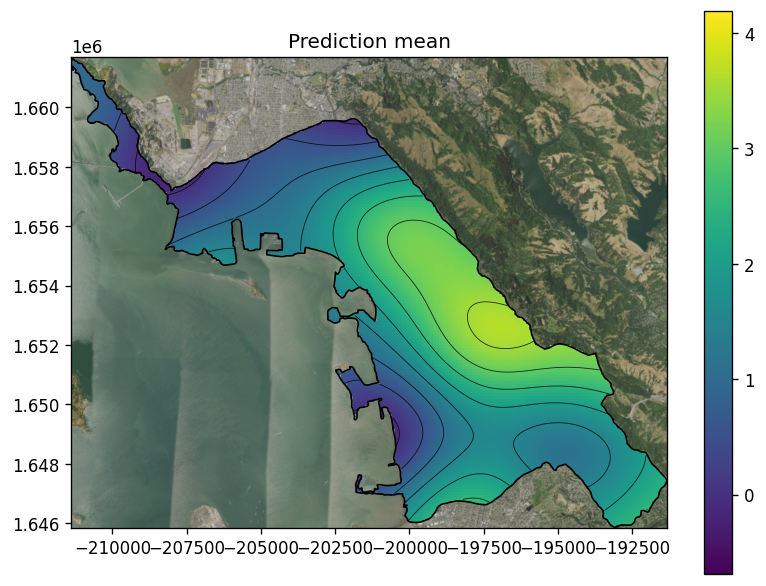

In [15]:
meshx, meshy, value = mesh.slice(mean)

fig, ax = pp.subplots(figsize=(7, 7), dpi=120)

cax = pp.pcolormesh(meshx, meshy, value, vmin=vmin, vmax=vmax)

# Add contour
value_contains = shv.contains(berkeleydf.geometry.item(), meshx, meshy)
value_mask = np.where(value_contains, value, np.nan)
pp.contour(meshx, meshy, value_mask, colors='k', linewidths=0.5, alpha=0.8)


berkeleydf.plot(ax=ax, fc='none', ec='black', lw=1)

pp.colorbar(cax, shrink=0.7)

ctx.add_basemap(ax, attribution=False, crs=berkeleydf.crs.to_string(), 
                source='https://basemap.nationalmap.gov/arcgis/rest/services/'
                       'USGSImageryOnly/MapServer/tile/{z}/{y}/{x}')

pp.title('Prediction mean')

pp.tight_layout()
pp.show()

Do the same for prediction variance:

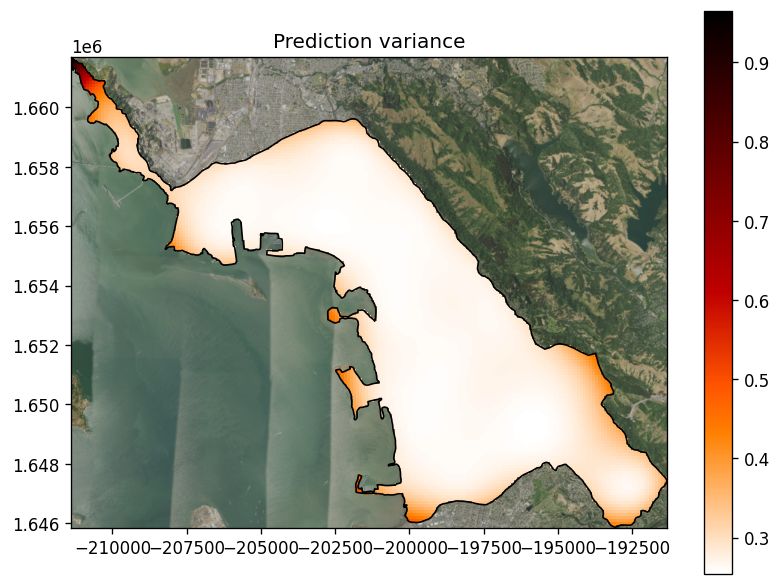

In [16]:
meshx, meshy, value = mesh.slice(var)

fig, ax = pp.subplots(figsize=(7, 7), dpi=120)

cax = pp.pcolormesh(meshx, meshy, value, cmap='gist_heat_r')

berkeleydf.plot(ax=ax, fc='none', ec='black', lw=1)

pp.colorbar(cax, shrink=0.7)

ctx.add_basemap(ax, attribution=False, crs=berkeleydf.crs.to_string(), 
                source='https://basemap.nationalmap.gov/arcgis/rest/services/'
                       'USGSImageryOnly/MapServer/tile/{z}/{y}/{x}')

pp.title('Prediction variance')

pp.tight_layout()
pp.show()